# Aerodynamic Splatting

In [1]:
import numpy as np
from sympy import symbols, diff, Quaternion, exp, Matrix, lambdify, sin, cos, simplify
#from sympy.physics.mechanics import *
import random
from IPython.display import display
import matplotlib.pyplot as plt
from aerosplat import *

aerosplat imported gaussian
<function <lambda> at 0x7f9ff0527b00>


## Symbolic Math

## Equation for quaternion
We provide two options for obtaining the quaternon.
In the case where a `numpy` array with four quaternion components are provided, we will obtain using the standard syntax `Quaternion(qw, qx, qy, qz)`.
In the case where a single component is provided, we will assume that this is a planar model with an angle evaluated about the $z$-axis, and obtain with the `Quaternion.from_axis_angle` class method.
We also will create the `idx_dimension` variable which shrinks subsequent matrices and vectors to use only the first two ($x$ and $y$) components.

In [2]:
display(quaternion_2d)

cos(θ/2) + 0*i + 0*j + sin(θ/2)*k

In [3]:
display(quaternion_3d)

q_w + q_x*i + q_y*j + q_z*k

## Equation for gaussian

The Gaussian equation that is created below uses the variance term _not-squared_, while in the plot I square this term.
There is reason for this; the variance that I will use below is going to be of the form

$\texttt{variance} = \sum_{i=1}^3 \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2$

where $x_i$ is a position coordinate for where we are measuring, $\bar{x}_i$ is the position coordinate for the center of the Gaussian, and $s_i$ is a scale coefficient representing one standard deviation in the direction of that coordinate.
Traditionally, we would evaluate the Gaussian at some count of standard deviations, which would derive from the square-root of the above expression.
To avoid taking a square-root, just to subsequently square the term again, we create the Gaussian as a function of the variance directly.
However, the plot below shows an evaluation of the Gaussian with respect to standard deviations.

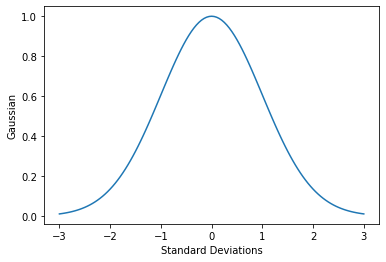

In [4]:
stdev = np.linspace(-3, 3, 121);
plt.plot(stdev, np.exp(-0.5 * stdev**2));
plt.xlabel("Standard Deviations");
plt.ylabel("Gaussian");

Here we create a function that obtains the rotation matrix from the quaternion, along with some simplification steps.
First, we substitute a value of 1 for the quaternion norm, as we will ensure that it is always a proper unit quaternion.
Second, we call the standard `simplify()` function.

In [5]:
display(rotation_eqn_2d)

Matrix([
[cos(θ), -sin(θ)],
[sin(θ),  cos(θ)]])

In [6]:
display(rotation_eqn_3d)

Matrix([
[-2*q_y**2 - 2*q_z**2 + 1,   -2*q_w*q_z + 2*q_x*q_y,    2*q_w*q_y + 2*q_x*q_z],
[   2*q_w*q_z + 2*q_x*q_y, -2*q_x**2 - 2*q_z**2 + 1,   -2*q_w*q_x + 2*q_y*q_z],
[  -2*q_w*q_y + 2*q_x*q_z,    2*q_w*q_x + 2*q_y*q_z, -2*q_x**2 - 2*q_y**2 + 1]])

Velocity away from the center of the Gaussian takes the form

$\boldsymbol{x} = (x, y, z, u, v, w, s_x, s_y, s_z, q_w, q_x, q_y, q_z)$

$\boldsymbol{x}_p = (x_p, y_p, z_p)$

$\boldsymbol{v(\boldsymbol{x}, \boldsymbol{x}_p)} = \boldsymbol{v_0(\boldsymbol{x})} g(\boldsymbol{x}, \boldsymbol{x}_p)$

In [7]:
display(Matrix(velocity_eqn_2d))

Matrix([
[u*exp(-0.5*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 - 0.5*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2)],
[v*exp(-0.5*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 - 0.5*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2)]])

We see the variance contained in the exponent

In [8]:
display(variance_eqn_2d)

((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 + ((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2

### Velocity derivative equations

Velocity is 1x2 or 1x3

Variance derivates are 1xN

$$
\frac{\partial \boldsymbol{v(\boldsymbol{x}, \boldsymbol{x}_p)} }{\partial x_i}
= 
\frac{\partial \boldsymbol{v_0(\boldsymbol{x})}}{\partial x_i}
g(\boldsymbol{x}, \boldsymbol{x}_p)
+
\boldsymbol{v_0(\boldsymbol{x})}
\frac{\partial g(\boldsymbol{x}, \boldsymbol{x}_p)}{\partial x_i}
$$

## Create Splatting Class

In [9]:
"""class AeroSplat:
    position = np.zeros(3)
    velocity = np.zeros(3)
    scale = np.ones(3)
    orientation = np.array([1, 0, 0, 0])
    
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, np.array(value))
    
    def __repr__(self):
        return f"AeroSplat(position={self.position}, velocity={self.velocity}, scale={self.scale}, orientation={self.orientation})"
    
    @property
    def is2d(self):
        return len(self.position) == 2
    
    @property
    def properties(self):
        return np.concatenate([self.position, self.velocity, self.scale, self.orientation])
    
    @property
    def quaternion(self):
        return quat(*self.orientation) if self.is2d else quat(self.orientation)
    
    @property
    def rotation_matrix(self):
        return rotation_fcn_2d(*self.orientation) if self.is2d else rotation_fcn_3d(*self.orientation)
    
    @property
    def scale_matrix(self):
        return np.diag(self.scale)
    
    def properties_at(self, position):
        return list(self.properties) + list(position)

    def variance_at(self, position):
        f = variance_fcn_2d if self.is2d else variance_fcn_3d
        return f(*self.properties_at(position))

    def variance_gradient_at(self, position):
        f = variance_gradient_fcn_2d if self.is2d else variance_gradient_fcn_3d
        gradient = f(*self.properties_at(position))
        return np.array(gradient)

    def gaussian_at(self, position):
        return np.exp(-0.5 * self.variance_at(position))

    def gaussian_gradient_at(self, position):
        return -0.5 * self.variance_gradient_at(position) * self.gaussian_at(position)

    def velocity_at(self, position):
        return self.velocity * self.gaussian_at(position)
    
    def velocity_gradient_at(self, position):
        return self.velocity * self.gaussian_gradient_at(position)

    def differential_velocity_at(self, position):
        f = diff_velocity_fcn_2d if self.is2d else diff_velocity_fcn_3d
        return f(*self.properties_at(position))
"""
        

In [10]:
a = AeroSplat(
    position=[0, 0], 
    velocity=[1, 0],
    scale=[1, 1],
    orientation=[0]
)
display(a)
display(a.quaternion)
display(a.rotation_matrix)
display(a.velocity_at(np.array([2, 0])))
display(a.differential_velocity_at(np.array([2, 0])))

AeroSplat(position=[0 0], velocity=[1 0], scale=[1 1], orientation=[0])

1 + 0*i + 0*j + 0*k

array([[ 1., -0.],
       [ 0.,  1.]])

array([0.13533528, 0.        ])

array([[ 0.27067057,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.13533528,  0.        ],
       [ 0.        ,  0.13533528],
       [ 0.54134113,  0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ]])

## Create Boundary Condition Class

In [11]:
class LineBoundary:
    point0 = np.zeros(3)
    point1 = np.zeros(3)
    velocity = np.zeros(3)
    
    def __init__(self, point0=[0, 0, 0], point1=[0, 0, 0], velocity=[0, 0, 0]):
        self.point0 = np.array(point0)
        self.point1 = np.array(point1)
        self.velocity = np.array(velocity)
        
    def __repr__(self):
        return f"LineBoundary(point0={self.point0}, point1={self.point1}, velocity={self.velocity})"
    
    def point_at(self, weighted_distance):
        return (1 - weighted_distance) * self.point0 + weighted_distance * self.point1
    
    def point_at_random(self):
        return self.point_at(random.uniform(0, 1))

In [12]:
source_boundary = LineBoundary(point0=[0, -1], point1=[0, 1], velocity=[10, 0])
plate_boundary = LineBoundary(point0=[1, -0.1], point1=[1, 0.1], velocity=[0, 0])
print(source_boundary)
print(source_boundary.point_at_random())

LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0])
[ 0.         -0.64077058]


## Create Problem Definition Class

In [13]:
class AeroSplatProblem:
    domain_x = np.zeros(2)
    domain_y = np.zeros(2)
    domain_z = np.zeros(2)
    
    splats = []
    boundaries = []
    
    def __init__(self, domain_x=[0, 0], domain_y=[0, 0], domain_z=[0, 0], boundaries=[], spawn: int = None):
        self.domain_x = np.array(domain_x)
        self.domain_y = np.array(domain_y)
        self.domain_z = np.array(domain_z)
        self.boundaries = boundaries
        if spawn:
            self.spawn_random_splats(spawn)

    def __repr__(self):
        repr_str = "AeroSplatProblem("
        repr_str += f"\n  domain_x={self.domain_x}" if not all(self.domain_x == 0) else ""
        repr_str += f"\n  domain_y={self.domain_y}" if not all(self.domain_y == 0) else ""
        repr_str += f"\n  domain_z={self.domain_z}" if not all(self.domain_z == 0) else ""
        repr_str += f"\n  boundaries={self.boundaries}" if self.boundaries else ""
        repr_str += "\n)"
        return repr_str
    
    @property
    def ndims(self):
        return 3 if self.domain_z[1] != self.domain_z[0] else 2
    
    def point_at_random(self):
        x = random.uniform(*self.domain_x)
        y = random.uniform(*self.domain_y)
        z = random.uniform(*self.domain_z)
        return np.array([x, y, z]) if self.ndims == 3 else np.array([x, y])
    
    def point_at_weights(self, weight_x, weight_y, weight_z):
        weights = weight_x, weight_y, weight_z
        domains = self.domain_x, self.domain_y, self.domain_z
        return [(1-w)*d[0] + w*d[1] for w, d in zip(weights, domains)]

    def point_grid(self, nx=10, ny=10, nz=1):
        grid = [[[self.point_at_weights(k/(nx-1), j/(ny-1), i/(nz-1) if nz > 1 else 0) 
                  for k in range(nx)] for j in range(ny)] for i in range(nz)]
        grid = np.array(grid)
        # grid will be in [page->z][row->y][column->x] index ordering
        return grid if self.ndims == 3 else grid[0, :, :, :2]

    def random_splat(self):
        return AeroSplat(
            position=self.point_at_random(),
            velocity=np.array(np.random.normal(size=self.ndims)), #np.zeros(self.ndims),
            scale=0.1 + 0.2*np.array(np.random.uniform(size=self.ndims)), #0.1*np.ones(self.ndims),
            orientation=[0] if self.ndims == 2 else [1, 0, 0, 0]
        )

    def spawn_random_splats(self, quantity, clear=True):
        self.splats = [] if clear else self.splats
        for _ in range(quantity):
            self.splats.append(self.random_splat())

    def velocity_on_grid(self, nx=10, ny=10, nz=1):
        grid = self.point_grid(nx, ny, nz)
        velocity_grid = np.zeros(grid.shape)
        if self.ndims == 2:
            velocity_grid = [[sum([splat.velocity_at(grid[j, k]) for splat in self.splats]) 
                              for k in range(nx)] for j in range(ny)]
        else:
            velocity_grid = [[[sum([splat.velocity_at(grid[i, j, k]) for splat in self.splats]) 
                              for k in range(nx)] for j in range(ny)] for i in range(nz)]
        return np.array(velocity_grid)
    
    def velocity_gradient_on_grid(self, nx=10, ny=10, nz=1):
        grid = self.point_grid(nx, ny, nz)
        gradient_grid = np.zeros(grid.shape)
        if self.ndims == 2:
            gradient_grid = [[sum([splat.velocity_gradient_at(grid[j, k]) for splat in self.splats]) 
                              for k in range(nx)] for j in range(ny)]
        else:
            gradient_grid = [[[sum([splat.velocity_gradient_at(grid[i, j, k]) for splat in self.splats]) 
                              for k in range(nx)] for j in range(ny)] for i in range(nz)]
        return np.array(gradient_grid)

In [14]:
problem = AeroSplatProblem(
    domain_x=[0, 2], 
    domain_y=[-1, 1],
    boundaries=[source_boundary, plate_boundary],
    spawn=20
)
print(problem)

AeroSplatProblem(
  domain_x=[0 2]
  domain_y=[-1  1]
  boundaries=[LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0]), LineBoundary(point0=[ 1.  -0.1], point1=[1.  0.1], velocity=[0 0])]
)


In [15]:
print(problem.velocity_on_grid(2, 2))
print(problem.ndims)
print(problem.splats)

[[[-8.41777422e-01 -7.44465909e-01]
  [-9.59918401e-01  6.08853382e-01]]

 [[ 2.16760980e-04 -5.56804477e-04]
  [-8.45335815e-04 -8.96636644e-05]]]
2
[AeroSplat(position=[0.61467757 0.58807811], velocity=[ 1.73611898 -0.1905285 ], scale=[0.15967881 0.1071778 ], orientation=[0]), AeroSplat(position=[0.427972   0.64685306], velocity=[ 0.0339768  -0.08813907], scale=[0.14730382 0.27107988], orientation=[0]), AeroSplat(position=[ 0.97328105 -0.07538284], velocity=[ 0.23639792 -1.11928541], scale=[0.22528168 0.21287876], orientation=[0]), AeroSplat(position=[ 1.81391574 -0.92014774], velocity=[-1.42972857  0.91247984], scale=[0.24010989 0.18673362], orientation=[0]), AeroSplat(position=[ 1.42044494 -0.6479621 ], velocity=[-0.36487521  0.14664008], scale=[0.20091629 0.15739367], orientation=[0]), AeroSplat(position=[ 0.78922503 -0.27874885], velocity=[ 0.03695876 -1.07783632], scale=[0.15687266 0.13543356], orientation=[0]), AeroSplat(position=[1.32707054 0.59061288], velocity=[-0.19600866 -

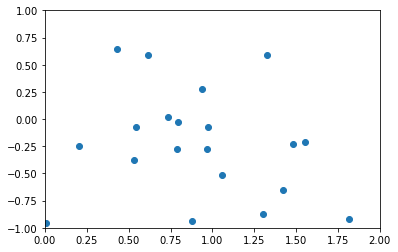

In [16]:
splat_positions = np.array([[splat.position[0], splat.position[1]] for splat in problem.splats])
plt.plot(splat_positions[:, 0], splat_positions[:, 1], "o");
plt.xlim(problem.domain_x);
plt.ylim(problem.domain_y);

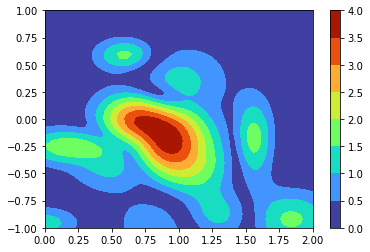

In [17]:
nx = 101
ny = 51
grid = problem.point_grid(nx, ny)
velocity_field = problem.velocity_on_grid(nx, ny)
contour_x = np.array([grid[0, k, 0] for k in range(nx)])
contour_y = np.array([grid[j, 0, 1] for j in range(ny)])
contour_z = np.array([[np.linalg.norm(velocity_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, contour_z, cmap="turbo");
plt.colorbar();

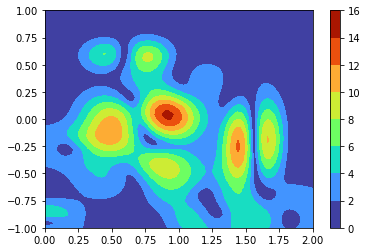

In [18]:
gradient_field = problem.velocity_gradient_on_grid(nx, ny)
contour_z = np.array([[np.linalg.norm(gradient_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, contour_z, cmap="turbo");
plt.colorbar();